# Assignment 1
Link: https://github.com/sepehrilami/CNET5442

February 2026

Sepehr Ilami

## Question 0

In [2]:
!conda env list

# conda environments:
#
base                     /Users/sepehr/miniconda
AgentSpeakEnv            /Users/sepehr/miniconda/envs/AgentSpeakEnv
cnet5442              *  /Users/sepehr/miniconda/envs/cnet5442
gametheory               /Users/sepehr/miniconda/envs/gametheory
gt                       /Users/sepehr/miniconda/envs/gt
llmrl                    /Users/sepehr/miniconda/envs/llmrl
mobility                 /Users/sepehr/miniconda/envs/mobility



## Question 1

In [3]:
# --- Imports and setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import zipfile

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 60)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

print("Ready.")

Ready.


### a)

In [4]:
# load Salaries.csv
dir_path = "../data"

data_path = Path(dir_path) / "Salaries.csv"
salaries = pd.read_csv(data_path)
print(salaries.head())
print(salaries.shape)

   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000
(26428, 5)


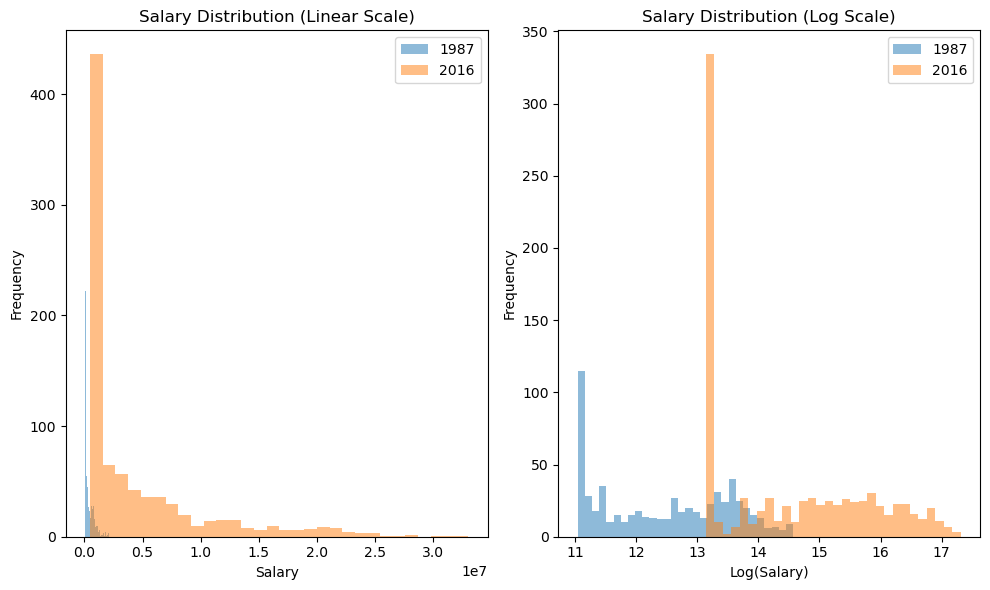

In [5]:
early_year = 1987
late_year = 2016

fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=100)

salaries_early = salaries[salaries["yearID"] == early_year]
'''Make one figure with two subplots
of the player salary distribution: 1) one plot on a linear salary scale, and 2) one
plot on a log salary scale (or equivalently, the distribution of log(salary)).'''

# add both years to both plots
salaries_late = salaries[salaries["yearID"] == late_year]

axes[0].hist(salaries_early["salary"], bins=30, alpha=0.5, label=str(early_year))
axes[0].hist(salaries_late["salary"], bins=30, alpha=0.5, label=str(late_year))
axes[0].set_title("Salary Distribution (Linear Scale)")
axes[0].set_xlabel("Salary")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].hist(np.log(salaries_early["salary"]), bins=30, alpha=0.5, label=str(early_year))
axes[1].hist(np.log(salaries_late["salary"]), bins=30, alpha=0.5, label=str(late_year))
axes[1].set_title("Salary Distribution (Log Scale)")
axes[1].set_xlabel("Log(Salary)")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

Both plots show how the distribution of salaries has changed over the years. It can be observed that the salaries have generally increased over time, with a noticeable rise in both the minimum and (especially) maximum salary values, and also in the range of salaries.

The log plot is particularly useful for visualizing data that spans several orders of magnitude, as it compresses the scale and allows for better visibility of smaller values. In this case, the log plot helps to highlight the growth in salaries more clearly, especially for lower salary ranges that are less visible in the linear plot.

### b)

In [6]:
'''For each of your two years, report at least four summary statistics (e.g., mean,
median, mode, 90th percentile, 99th percentile, max). Explain why mean and
median can behave differently in a right-skewed distribution'''

years = [early_year, late_year]
summary_stats = {}
for year in years:
    salaries_year = salaries[salaries["yearID"] == year]["salary"]
    summary_stats[year] = {
        "Mean": salaries_year.mean(),
        "Median": salaries_year.median(),
        "Mode": salaries_year.mode().iloc[0] if not salaries_year.mode().empty else np.nan,
        "90th Percentile": salaries_year.quantile(0.9),
        "99th Percentile": salaries_year.quantile(0.99),
        "Max": salaries_year.max()
    }

# make them all scientific notation
for year in summary_stats:
    for stat in summary_stats[year]:
        summary_stats[year][stat] = f"{summary_stats[year][stat]:.2e}"

summary_df = pd.DataFrame(summary_stats).T
display(summary_df)

,Mean,Median,Mode,90th Percentile,99th Percentile,Max
1987,4.35e+05,2.85e+05,6.25e+04,1.00e+06,1.94e+06,2.13e+06
2016,4.40e+06,1.50e+06,5.08e+05,1.26e+07,2.50e+07,3.30e+07


I showed all values in scientific notation, which can clearly tell us how all of those metrics increased by an order of magnitude over the years.
The reason why mean and median are so different in both distributions but more in the late year—as a very right-skewed distribution—is that there are some super high salaries that pull the mean up, while the median remains stable as it is the middle value of the distribution.

### c)

Gini coefficient is a measure of income inequality within a population, mostly used in economics, especially to compare how people across different groups or regions are distributed in terms of income.

It ranges from 0 to 1, where 0 represents perfect equality (everyone has the same income) and 1 represents perfect inequality (one person has all the income, and everyone else has none). Some random fact: Super wealthy countries do not necessarily have low Gini coefficients; for example, USA has a Gini coefficient of around 0.41, indicating a relatively high level of income inequality compared to other developed nations. This shows a few people have SO MUCH more wealth than the rest of the population. And in the other hand, some countries with very low gini coefficients, do not necessarily have high average income; for example, Belarus has a Gini coefficient of around 0.25, indicating a more equal distribution of income among its population, but the average income is relatively low compared to wealthier nations. It means that wealth is more evenly spread out, but the overall wealth is not very high. Everyone are [equally] poor.

The formula is:
G = (1 / (2 * n^2 * μ)) * ΣΣ |xi - xj|
Where:
- G is the Gini coefficient.
- n is the number of individuals in the population.
- μ is the mean income of the population.
- xi and xj are the incomes of individuals i and j, respectively.



In [7]:
def gini_coefficient(salaries):
    """Compute the Gini coefficient of a numpy array."""
    # Ensure the array is sorted. This is very important.
    sorted_salaries = np.sort(salaries)
    n = len(salaries)
    cumulative_salaries = np.cumsum(sorted_salaries)
    gini = (2 * np.sum((np.arange(1, n + 1) * sorted_salaries))) / (n * cumulative_salaries[-1]) - (n + 1) / n
    return gini

gini_early = gini_coefficient(salaries_early["salary"].values)
gini_late = gini_coefficient(salaries_late["salary"].values)

print(f"Gini Coefficient in {early_year}: {gini_early:.4f}")
print(f"Gini Coefficient in {late_year}: {gini_late:.4f}")

Gini Coefficient in 1987: 0.5104
Gini Coefficient in 2016: 0.6247


### d)

      Gini Coefficient
Year                  
1985          0.384328
1986          0.488756
1987          0.510426
1988          0.507338
1989          0.532834


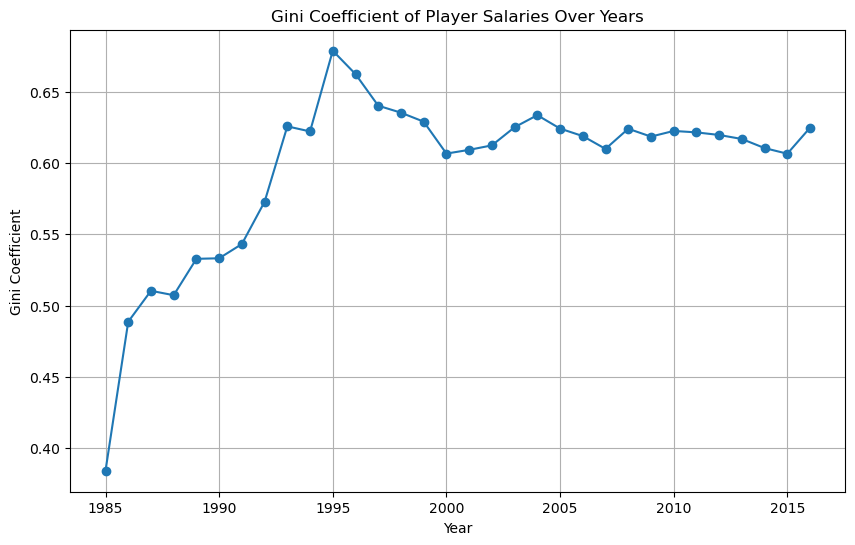

In [8]:
# compute gini coefficients for every year in the dataset
gini_by_year = {}
for year in salaries["yearID"].unique():
    salaries_year = salaries[salaries["yearID"] == year]["salary"].values
    gini_by_year[year] = gini_coefficient(salaries_year)
gini_df = pd.DataFrame.from_dict(gini_by_year, orient='index', columns=['Gini Coefficient'])
gini_df.index.name = 'Year'
print(gini_df.head())

# plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.plot(gini_df.index, gini_df['Gini Coefficient'], marker='o')
ax.set_title("Gini Coefficient of Player Salaries Over Years")
ax.set_xlabel("Year")
ax.set_ylabel("Gini Coefficient")
plt.grid()
plt.show()

As expected, the Gini coefficient has increased from ~0.40 in 1985 to over 0.65 in 1995, and remained stable after that, indicating a rise in income inequality over the decade. This suggests that the distribution of salaries has become more unequal, due to the fact that there was uneven revenue growth in the teams. This could be related to the tech industry and analytical methods that boomed in the 90s, which led to some teams and players earning significantly more than others, thus increasing the overall income inequality within the league.

## Question 2

### a)

Define the following terms:
1) Standard error: The standard error of an estimate is the standard deviation of the sampling distribution of that estimate. It measures the precision of an estimate. If it is small, it indicates that the estimate is likely to be close to the true population parameter. Note: The reason we have such thing at all is because sampling populations can never be equal to the actual population, so we need a way to measure how far off we are likely to be.
2) Heteroskedasticity: The condition where the variance of the error terms in a regression model is not constant across observations. Imagine plotting the residuals of a regression model against the predicted values. If the spread of the residuals increases or decreases as the predicted values change, this indicates heteroskedasticity. This violates one of the key assumptions of ordinary least squares (OLS) regression, which assumes that the variance of the error terms is constant (homoskedasticity). Heteroskedasticity can lead to inefficient estimates and invalid statistical inferences if not addressed properly.
3) Multicollinearity: The presence of high correlation among independent variables in a regression model, which can make it difficult to assess the individual effect of each variable. When independent variables are highly correlated, it can lead to unstable estimates of regression coefficients, making it challenging to determine the true relationship between each independent variable and the dependent variable. This can result in inflated standard errors and reduced statistical power.
4) Fixed effects: A method for controlling unobserved heterogeneity in panel data by including dummy variables for each entity (e.g., each player or team or year).

### b)

In [ ]:
Master = pd.read_csv(Path(dir_path) / "Master_built.csv")

#### Last model in the class:

In [11]:
MB_Data = Master[(Master["SalYear"] >= 2000) & (Master["SalYear"] <= 2004)].copy()
MB_Data_Pre = Master[(Master["SalYear"] >= 2000) & (Master["SalYear"] <= 2003)].copy()

formula = "lnSal ~ OBP + SLG + PA + Arb + Free + Catch + Infld"

Val_All_lm = smf.ols(formula=formula, data=MB_Data).fit()
Val_Pre_lm = smf.ols(formula=formula, data=MB_Data_Pre).fit()

# Year-by-year
Val_year = {}
for y in [2000,2001,2002,2003,2004]:
    Val_year[y] = smf.ols(formula=formula, data=Master[Master["SalYear"] == y]).fit()

Val_All_lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lnSal   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     485.7
Date:                Sun, 08 Feb 2026   Prob (F-statistic):               0.00
Time:                        20:05:06   Log-Likelihood:                -1928.6
No. Observations:                1741   AIC:                             3873.
Df Residuals:                    1733   BIC:                             3917.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1090      0.164     61.773      0.000       9.788      10.430
OBP            1.4783      0.628      2.355      0.019       0.247       2.709
SLG            2.3884      0.316      7.553      0.000       1.768       3.009
PA             0.0031      0.000     25.962      0.000       0.003       0.003
Arb            1.2076      0.049     24.585      0.000       1.111       1.304
Free           1.8050      0.049     37.033      0.000       1.709       1.901
Catch          0.1115      0.057      1.972      0.049       0.001       0.222
Infld         -0.0502      0.041     -1.231      0.219      -0.130       0.030
==============================================================================
Omnibus:                        5.756   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                6.893
Skew:                           0.026   Prob(JB):                       0.0319
Kurtosis:                       3.304   Cond. No.                     1.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Pearson correlation between OBP and SLG: 0.7032


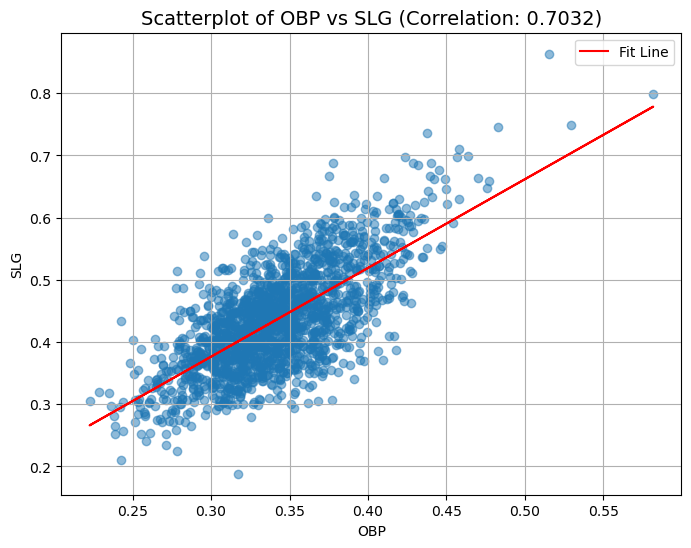

In [19]:
# CORR between OBP and SLG
correlation = MB_Data["OBP"].corr(MB_Data["SLG"])
print(f"Pearson correlation between OBP and SLG: {correlation:.4f}")

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.scatter(MB_Data["OBP"], MB_Data["SLG"], alpha=0.5)
ax.set_title(f"Scatterplot of OBP vs SLG (Correlation: {correlation:.4f})", fontsize=14)
ax.set_xlabel("OBP")
ax.set_ylabel("SLG")
# fit a line to the data
m, b = np.polyfit(MB_Data["OBP"], MB_Data["SLG"], 1)
ax.plot(MB_Data["OBP"], m * MB_Data["OBP"] + b, color='red', label='Fit Line')
ax.legend()
ax.grid()
plt.show()

The scatter plot above shows how strongly OBP (On-Base Percentage) is correlated with SLG (Slugging Percentage) overall. This means that it would be difficult to include both of these variables in a regression model without running into multicollinearity issues, as they are likely to provide redundant information about a player's offensive performance. In other words, including both OBP and SLG in the same model may not add much explanatory power and even could lead to unstable coefficient estimates due to their high correlation. That's a big problem.

### c)

VIF or variance inflation factor is a measure of how much the variance of an estimated regression coefficient increases due to multicollinearity. In simple terms, you want those variables to be independent. VIF tells you if your independent variables are getting in each other's way by being too similar. A VIF of 1 means no correlation between the independent variable and any other variables, while a VIF above 5 or 10 indicates a high level of multicollinearity, which can be problematic for regression analysis. In the context of our model, if we find that OBP and SLG have high VIF values, it would suggest that including both in the same model may not be advisable due to the multicollinearity issue.

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = MB_Data[["OBP", "SLG", "PA", "Arb", "Free", "Catch", "Infld"]]
X = sm.add_constant(X)  # add intercept term
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  feature        VIF
0   const  86.482440
1     OBP   2.087089
2     SLG   2.181378
3      PA   1.351325
4     Arb   1.829801
5    Free   1.868664
6   Catch   1.218236
7   Infld   1.225179


Hmm.. I'm actually surprised that the VIF values for OBP and SLG are not higher, given their strong correlation. This could be due to the presence of other variables in the model that are helping to mitigate the multicollinearity issue, or it could be that the correlation between OBP and SLG is not as high as it appears in the scatter plot when controlling for other factors. It's also possible that the sample size is large enough to allow for some degree of multicollinearity without causing significant issues in the regression analysis. However, it's still important to be cautious when interpreting the results of a model that includes highly correlated variables, as it can lead to unstable coefficient estimates and make it difficult to determine the true effect of each variable on the dependent variable.

Let's try a simple model with only OBP and SLG as independent variables, and see what happens to the VIF values:

In [26]:
formula_simple = "lnSal ~ OBP + SLG"
Val_simple_lm = smf.ols(formula=formula_simple, data=MB_Data).fit()
Val_simple_lm.summary()

# report VIF values for the simple model
X_simple = MB_Data[["OBP", "SLG"]]
X_simple = sm.add_constant(X_simple)  # add intercept term
vif_simple_data = pd.DataFrame()
vif_simple_data["feature"] = X_simple.columns
vif_simple_data["VIF"] = [variance_inflation_factor(X_simple.values, i) for i in range(X_simple.shape[1])]
print(vif_simple_data)

  feature        VIF
0   const  72.805450
1     OBP   1.978155
2     SLG   1.978155


Nope. Even when we have only those two variables, the VIF values are still not very high. This suggests that while OBP and SLG are correlated, they may not be causing severe multicollinearity issues in the regression model. However, it's still important to consider the potential implications of including both variables in the same model, as their correlation could still affect the interpretability of the coefficients (So likely).

### d)

In [27]:
# starting by baseline formula lnSal ~ OBP + SLG, and add 7 other variables one by one, and the FEs. Create a table with 10 models and report the R-squared and adjusted R-squared for each model. Also, report the coefficients and standard errors for OBP and SLG in each model to see how they change as we add more variables and fixed effects.

# let see what columns we have in the dataset
print(MB_Data.columns)

Index(['playerID', 'yearID', 'stint', 'G', 'AB', 'R', 'H', 'Doubles',
       'Triples', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP', 'PA', 'OBP', 'SLG', 'SalYear', 'teamID', 'lgID', 'salary',
       'lnSal', 'debutyr', 'Exp', 'Arb', 'Free', 'POS', 'Catch', 'Infld'],
      dtype='str')


In [41]:
base_formula = "lnSal ~ OBP + SLG"
formulas = [
    base_formula,
    base_formula + " + PA",
    base_formula + " + PA + Arb",
    base_formula + " + PA + Arb + Free",
    base_formula + " + PA + Arb + Free + Catch",
    base_formula + " + PA + Arb + Free + Catch + Infld",
    base_formula + " + PA + Arb + Free + Catch + Infld + H",
    base_formula + " + PA + Arb + Free + Catch + Infld + H + HR",
    base_formula + " + PA + Arb + Free + Catch + Infld + H + HR + R",
    base_formula + " + PA + Arb + Free + Catch + Infld + H + HR + R + Doubles",
    base_formula + " + PA + Arb + Free + Catch + Infld + H + HR + R + Doubles + Triples",
    base_formula + " + PA + Arb + Free + Catch + Infld + H + HR + R + Doubles + Triples + C(yearID)",
    base_formula + " + PA + Arb + Free + Catch + Infld + H + HR + R + Doubles + Triples + C(playerID)",
    base_formula + " + PA + Arb + Free + Catch + Infld + H + HR + R + Doubles + Triples + C(yearID) + C(playerID)"
]

models = []
for formula in formulas:
    model = smf.ols(formula=formula, data=MB_Data).fit()
    models.append(model)

all_vars = models[-1].params.index.tolist()
keep_vars = [v for v in all_vars if 'ID' not in v]

model_summaries = summary_col(models, regressor_order=keep_vars,
                                drop_omitted=True,
                                stars=True, float_format='%0.4f',
                                model_names=[f'Model {i+1}' for i in range(len(models))],
                                info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}",
                                         'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}",
                                         'Num. obs.': lambda x: f"{int(x.nobs)}",
                                         'F-statistic': lambda x: f"{x.fvalue:.2f}",
                                         'AIC': lambda x: f"{x.aic:.2f}",
                                         'BIC': lambda x: f"{x.bic:.2f}",
                                         'VIF OBP': lambda x: f"{variance_inflation_factor(x.model.exog, 1):.2f}",
                                         'VIF SLG': lambda x: f"{variance_inflation_factor(x.model.exog, 2):.2f}",
                                         'FE Year': lambda x: 'Yes' if 'C(yearID)' in x.model.formula else 'No',
                                         'FE Player': lambda x: 'Yes' if 'C(playerID)' in x.model.formula else 'No'
                                         },
                                         )
print(model_summaries)


                Model 1   Model 2    Model 3    Model 4    Model 5    Model 6    Model 7   Model 8    Model 9    Model 10   Model 11   Model 12   Model 13   Model 14 
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept      9.9337*** 10.3760*** 10.3800*** 10.1234*** 10.0457*** 10.1090*** 9.9625*** 10.7694*** 10.9092*** 10.9714*** 10.8426*** 10.6412*** 10.2966*** 10.2113***
               (0.2280)  (0.2030)   (0.2047)   (0.1525)   (0.1554)   (0.1636)   (0.1829)  (0.2396)   (0.2516)   (0.2609)   (0.2629)   (0.2648)   (0.6604)   (0.6450)  
OBP            7.3206*** 4.0192***  4.0162***  1.3995**   1.5136**   1.4783**   1.6563*** 2.8038***  2.3796***  2.4716***  1.5821**   1.9310**   1.4225     1.9838*   
               (0.9281)  (0.8359)   (0.8364)   (0.6265)   (0.6271)   (0.6277)   (0.6351)  (0.6686)   (0.7080)   (0.7154)   (0.7601)   (0.7585)   (1.0552)   (1.0355)

**Definition of adjusted R-squared**: 
Adjusted R-squared is a modified version of R-squared that takes into account the number of independent variables in the model. It adjusts for the number of predictors and only increases if the new predictor improves the model more than would be expected by chance. It can go down if the added variable does not improve the model sufficiently, which is why it is often used to compare models with different numbers of predictors.

**Does the kitchen-sink model look better?**

Well, yes. Because adj R2 and all other metrics are highly improved, compared to the baseline model. However, not all variables were quite useful in this case (look how sometimes Adj R2 didn't change at all). But overall, the last model, especially with the fixed effects (mostly player FE), seems to be a good model. The AIC has also decreased significantly, which indicates a better fit of the model to the data. The coefficients for OBP and SLG have also changed as we added more variables and fixed effects, which suggests that the relationship between these variables and the dependent variable (lnSal) is influenced by other factors in the model. It's important to interpret these coefficients in the context of the other variables included in the model, as they may be capturing some of the effects that were previously attributed to OBP and SLG in the simpler models.

However, BIC has increased when adding the fixed effects, which suggests that the model may be overfitting the data. This is because BIC penalizes models with more parameters more heavily than AIC does. So while the kitchen-sink model may have a better fit to the data, it may not necessarily be the best model for making predictions or understanding the underlying relationships between the variables. It's important to consider both AIC and BIC when evaluating model performance, and to be cautious about adding too many variables or fixed effects that may lead to overfitting. Also, some important variables such as SLG lost their significance after model 7, which is another sign of overfitting. So overall, while the kitchen-sink model may look better in terms of fit, it may not be the best choice for making predictions or understanding the underlying relationships in the data.

## Question 3

### a)

Two papers are as below:

1) Ayana, G., Ehlert, A., Ehlert, J., Santagata, L., Torricelli, M., & Klein, B. (2025). Temporal dynamics of goal scoring in soccer. arXiv preprint arXiv:2501.18606.
Link: https://arxiv.org/abs/2501.18606

This paper investigates the temporal dynamics of goal scoring in soccer matches. The authors analyze a large dataset of soccer matches to identify patterns in goal scoring over time. They find that goals are more likely to be scored in certain periods of the match, such as the final minutes of each half, and that there are differences in goal-scoring patterns between different leagues and teams. The study provides insights into the strategic aspects of soccer and could have significant implications for coaching and game management.

2) A. Cao et al., "Team-Builder: Toward More Effective Lineup Selection in Soccer," in IEEE Transactions on Visualization and Computer Graphics, vol. 29, no. 12, pp. 5178-5193, Dec. 2023, doi: 10.1109/TVCG.2022.3207147.
Link: https://ieeexplore.ieee.org/abstract/document/9894103

This paper presents Team-Builder, a visual analytics system designed to assist coaches and analysts in selecting effective lineups for soccer matches. The system integrates various data sources, including player performance metrics, team dynamics, and historical match data, to provide insights into optimal lineup configurations. The authors demonstrate the effectiveness of Team-Builder through case studies and user evaluations, showing that it can help improve decision-making in lineup selection and enhance team performance.

### b)

#### Paper 1: "Temporal Dynamics of Goal Scoring in Soccer" (Ayana, Ehlert, Ehlert, Santagata, Torricelli, & Klein, 2025)

**1. Research Question / Hypothesis:**
The central question is: *Is the timing of goals in soccer randomly distributed across match time, or are there systematic temporal patterns?* The authors hypothesize that (a) goals are not uniformly distributed across match minutes, with certain intervals—such as the final minutes of each half—showing significantly elevated or depressed scoring rates, and (b) teams exhibit "bursty" goal-scoring behavior, meaning a team that just scored is more likely to score again shortly afterward than would be expected by chance.

**2. Data:**
The sport is soccer (football). The authors used event-level data from **Hudl StatsBomb's open dataset**, covering **3,433 matches** across **21 leagues and competitions** (including the FIFA World Cup, UCL, and top European leagues). The unit of analysis is the individual **goal event**, specifically its timestamp within a match. Key variables include the minute a goal was scored, the team that scored, the time interval between consecutive goals, and the remaining match time at the last goal. The dataset is for multiple seasons.

**3. Methods:**
The authors built a null model assuming goals are scored at a constant random rate, simulated 6 million fictitious games, and compared observed goal-timing distributions to this baseline using chi-squared tests and correlation analysis. They also examined the time intervals between consecutive goals, splitting by whether the same or opposing team scored next, and fit exponential decay curves.
In plain terms: they built a simple "what if goals were random?" baseline and then checked where real-world data departed from that baseline.

**4. Key Results:**
- Goal frequency is **not uniform** over match time. Goals are less frequent early in each half and become more frequent as the match progresses (χ² ≈ 288.62, p = 3.72 × 10⁻²¹). There is a noticeable dip around minutes 45–50, corresponding to the halftime restart.
- The overall distribution of time between consecutive goals follows an **exponential decay** that closely matches the null model (χ² ≈ 0.044, p = 1), meaning the raw clustering of goals near each other in time is largely explained by the constant average scoring rate rather than any special momentum effect.
- However, when splitting by *which team* scores next, **bursty behavior** emerges: the same team that just scored is more likely to score again sooner than expected, and the opposing team is less likely to score in the minutes immediately following a conceded goal. This divergence from the null model persists for roughly the first 30 minutes after a goal.
- Teams are more likely to score the **last goal** of a match very close to the final whistle than the null model predicts.

**5. Limitations:**
- **Sample bias:** The dataset is limited to what StatsBomb makes publicly available, which is not a random or comprehensive sample of all professional soccer. Certain leagues, seasons, and tiers of play are overrepresented or absent, so the findings may not generalize to all professional soccer worldwide.
- **Stoppage time measurement:** The handling of added/injury time at the end of halves can introduce noise, since the official minute stamps may not perfectly reflect actual elapsed playing time.
- **No causal mechanisms tested:** The paper identifies temporal patterns but does not directly measure the proposed explanatory factors (fatigue, tactical changes, substitutions, psychological momentum). The authors acknowledge these as possible drivers but cannot distinguish among them with goal-timing data alone.

---

#### Paper 2: "Team-Builder: Toward More Effective Lineup Selection in Soccer" (Cao, Lan, Xie, Chen, Zhang, Zhang, & Wu, 2023)

**1. Research Question / Hypothesis:**
How can a computational model and interactive visual system help coaches select optimal lineups by integrating individual performance, teammate interactions, opponent-specific defensive interactions, and tactical preferences? The implicit hypothesis is that a lineup selection model incorporating all of these factors—particularly defensive interactions with the specific upcoming opponent and spatio-temporal tactic information—will produce lineups that more closely match (or improve upon) what expert coaches choose in practice, compared to models that ignore opponent-specific and tactic-specific information.

**2. Data:**
The sport is again soccer. The authors used a **publicly available soccer event dataset** published by Pappalardo et al. (2019), containing spatio-temporal event records from all matches in the **five major European leagues** during **1,826 matches** involving **98 teams** and **4,229 players**. The unit of analysis is the **player and player-pair interaction** within and across matches. Key variables include event type (pass, shot, tackle, interception, etc.), event result (success/failure), spatial coordinates (start and end positions on the pitch), player identity and role (goalkeeper, defender, midfielder, forward), team identity, and match ID. The authors also extract higher-level constructs: *phases* (sequences of consecutive actions by one team), *offensive interactions* (consecutive actions by two teammates within a phase), *defensive interactions* (ball transitions between opponents across phases), and *tactics* (clusters of phases or defensive actions in similar spatial regions).

**3. Methods:**
The authors compute a "teamwork value" for each candidate lineup as a weighted sum of individual player performance (based on goal-probability changes), offensive interaction values between teammates, and defensive interaction values against opponents. They maximize this value using integer linear programming, with a tactic detection module that clusters phases by spatial similarity and up-weights interactions in coach-selected tactics. A random forest predicts match outcomes, and a visual analytics interface supports coach-driven exploration.

**4. Key Results:**
The model with defensive interactions produced lineups closer to real coach-selected lineups than the prior model without them, across all five leagues. Expert case studies confirmed the system generated sensible lineups and allowed coaches to understand, adjust, and compare selections.

**5. Limitations:**
- **No physical/mental condition data:** The model relies entirely on historical match event data and does not incorporate player fitness, injury status, fatigue, or psychological state—factors that coaches weigh heavily in real lineup decisions.
- **Coarse positional constraints:** Player roles are limited to the four basic categories (goalkeeper, defender, midfielder, forward), ignoring finer distinctions like left-winger vs. center-forward or defensive midfielder vs. attacking midfielder. This limits how precisely the model can respect formation requirements.
- **Only direct interactions modeled:** The model considers only direct (ball-mediated) interactions between two players. Indirect interactions—such as off-the-ball runs that create space for a teammate—are not captured, which omits a significant dimension of teamwork.
- **Single-season, single-dataset evaluation:** The model was trained and tested on one season of data from five leagues. Its generalizability to other seasons, lower-tier leagues, or international competitions is untested.
- **Qualitative evaluation only:** The system was evaluated via case studies and expert interviews rather than a controlled experiment or large-scale quantitative validation, making it difficult to draw strong conclusions about its superiority over alternative approaches in practice.

### c)

#### How the Two Papers Differ

These two papers address fundamentally different questions about soccer, though both use large-scale event data about soccer. Paper 1 is descriptive—asking when goals happen using simple statistical tests against a null model across many leagues. Paper 2 is prescriptive—asking which players to select using an optimization model with interactive visualization, focused on one season of top-league data.

Their methods also differ. Paper 1 uses relatively simple statistical tools—null model simulation, chi-squared tests, correlation, and exponential curve fitting—to characterize aggregate patterns across thousands of matches. Paper 2 uses a multi-component optimization framework (integer linear programming over a teamwork value function that combines individual VAEP-based performance scores, offensive interaction values, defensive interaction values, and tactic-weighted adjustments), combined with random forest prediction and an interactive visualization system. Paper 1 is purely analytical; Paper 2 is a system-building effort with a human-in-the-loop evaluation.

Where they converge is in the broader theme that soccer outcomes are shaped by context-dependent, dynamic factors—not just static player quality or random chance. Paper 1 shows that *when* in a match matters for scoring probability; Paper 2 shows that *which combinations* of players and *which tactical context* matter for team performance. Neither paper, however, connects these two dimensions to each other.

#### Follow-Up Research Question

**Proposed question:** *Does the timing of lineup changes (substitutions) causally affect the probability of scoring or conceding a goal in the minutes immediately following the substitution, and does this effect depend on the tactical and teamwork "fit" of the substituted player?*

This question bridges the two papers directly. Paper 1 established that goal-scoring probability rises in later match periods and that teams show bursty scoring after a goal, speculating that substitutions and tactical shifts may drive these patterns but not testing this directly. Paper 2 established that lineup composition—particularly the interaction values between specific players—matters for team performance, but only considered the starting eleven, not in-game lineup changes.

**Hypothesis:** Substitutions that introduce a player with high offensive interaction values with the players currently on the pitch (as measured by Paper 2's teamwork model) will produce a larger increase in goal-scoring probability in the 10–15 minutes post-substitution than substitutions that introduce a player with lower interaction values, controlling for match state (score differential, minute of substitution, home/away).

**Data needed:** Event-level data (as used in both papers) that includes substitution events with precise timestamps, the identity of the player entering and leaving, and all subsequent actions. Ideally, this would come from a dataset like StatsBomb or the Pappalardo et al. dataset, covering multiple leagues and seasons. The key addition is linking each substitution event to (a) the pre-computed offensive and defensive interaction values of the incoming player with the remaining 10 players on the pitch (from Paper 2's framework), and (b) the minute-by-minute goal probability estimates (from Paper 1's temporal framework).

**One method:** A **regression discontinuity or difference-in-differences design** centered on the substitution event. For each substitution, measure the team's goal-scoring rate (or expected threat / xG generation rate) in a window before the substitution (e.g., 10 minutes prior) and a window after (e.g., 10 minutes post), and model the change as a function of the incoming player's teamwork-value fit with the current lineup. A mixed-effects regression with match-level random intercepts could account for the nested structure. This would allow us to estimate whether "good-fit" substitutions produce a statistically significant bump in attacking output beyond what is explained by the general late-game increase in scoring documented in Paper 1.
